# Huấn luyện mô hình LeNet-5 (đã tối ưu

**Mục tiêu**: Bài toán cần giải quyết là nhận dạng cử chỉ tay từ hình ảnh, với tập dữ liệu gồm 36 lớp (các ký tự chữ cái và chữ số). Mô hình sẽ phân loại ảnh thành các ký hiệu cử chỉ tay tương ứng.

**Lý do chọn LeNet-5**:
- Mô hình LeNet-5 là một mạng nơ-ron tích chập (CNN) được thiết kế ban đầu để nhận dạng chữ viết tay.
- Mô hình này phù hợp cho bài toán nhận dạng cử chỉ tay từ hình ảnh.
- Mặc dù vậy, mô hình đã được điều chỉnh và tối ưu hóa để phù hợp hơn với tập dữ liệu phức tạp hiện tại.


**Bước 1: Cài đặt các thư viện cần thiết cho quá trình huấn luyện**

In [2]:
import os
import sys
import numpy as np
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from PIL import Image


In [3]:
warnings.filterwarnings("ignore")
checkpoint = ModelCheckpoint('../Scripts/best_model_lenet.h5', monitor='val_loss', save_best_only=True, mode='min')

**Bước 2: kiểm tra phần cứng để huấn luyện trên GPU thay vì CPU**

In [4]:
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Có GPU sẵn sàng.")
else:
    print("Không tìm thấy GPU.")
    sys.exit()

Có GPU sẵn sàng.


In [5]:
def load_data(data_dir):
    images = []
    labels = []
    class_names = os.listdir(data_dir)  # Lấy tên các lớp từ thư mục

    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):  # Kiểm tra xem đây có phải là thư mục không
            for filename in os.listdir(class_dir):
                if filename.endswith('.png') or filename.endswith('.jpg'):  # Kiểm tra định dạng tệp
                    img_path = os.path.join(class_dir, filename)
                    image = Image.open(img_path).convert('RGB')  # Chuyển đổi thành ảnh RGB
                    image = image.resize((32, 32))  # Thay đổi kích thước ảnh
                    images.append(np.array(image))
                    labels.append(class_names.index(label))  # Gán nhãn lớp

    return np.array(images), to_categorical(np.array(labels), num_classes=36)  # Trả về mảng NumPy của ảnh và nhãn

**Bước 3: Tải và xử lý dữ liệu trước khi đưa vào mô hình**:
   - đưa dữ liệu ảnh về dữ liệu mảng

In [6]:
train_dir = r'..\Data\Gesture Image Pre-Processed Data'
test_dir = r'..\Data\Gesture Image Pre-Processed Data - Test'

# Tải dữ liệu
X_train, Y_train = load_data(train_dir)
X_test, Y_test = load_data(test_dir)

**Các cải tiến trong mô hình LeNet-5 đã tối ưu**:

1. **Tăng số lượng bộ lọc**: Mô hình được tăng số lượng bộ lọc trong các lớp tích chập để học các đặc trưng chi tiết hơn từ ảnh đầu vào.

2. **Batch Normalization**: Thêm sau mỗi lớp tích chập để giúp mô hình hội tụ nhanh hơn và ổn định hơn trong quá trình huấn luyện.

3. **Dropout**: Thêm vào sau các lớp fully-connected nhằm giảm thiểu hiện tượng overfitting, giúp mô hình tổng quát hóa tốt hơn khi dự đoán trên dữ liệu mới.

4. **Tăng số lượng nơ-ron**: Số lượng nơ-ron trong các lớp fully-connected được tăng lên so với mô hình gốc để cải thiện khả năng học các đặc trưng phức tạp.

**Mục tiêu cuối cùng**: Tối ưu hóa mô hình để đạt được độ chính xác cao trên cả tập huấn luyện và tập kiểm tra, đồng thời ngăn chặn overfitting bằng các kỹ thuật như Batch Normalization, Dropout, và tối ưu hóa learning rate.

**Bước 4: Thực hiện huấn luyện mô hình**:


In [7]:
model = Sequential()

# Lớp tích chập đầu tiên
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))  # 3 kênh màu
model.add(BatchNormalization())
model.add(AveragePooling2D())

# Lớp tích chập thứ hai
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D())

# Lớp tích chập thứ ba
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D())

# Chuyển đổi đặc trưng thành vector
model.add(Flatten())

model.add(Dense(512, activation='relu'))  # Tăng số lượng nơ-ron
model.add(Dropout(0.5))  # Thêm lớp Dropout để giảm overfitting

model.add(Dense(256, activation='relu'))  # Tăng số lượng nơ-ron
model.add(Dropout(0.5))  # Thêm lớp Dropout để giảm overfitting

model.add(Dense(128, activation='relu'))  # Tăng số lượng nơ-ron
model.add(Dropout(0.5))  # Thêm lớp Dropout để giảm overfitting

# Lớp output với số lớp tương ứng
model.add(Dense(36, activation='softmax'))  # 36 lớp

# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Huấn luyện mô hình
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), batch_size=64,
                callbacks=[checkpoint, reduce_lr, early_stop])

# Lưu mô hình
#model.save('../Scripts/hand_sign_recognition_lenet5.h5')

Epoch 1/20
844/844 [==============================] - 25s 9ms/step - loss: 0.7926 - accuracy: 0.7681 - val_loss: 0.0055 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 2/20
844/844 [==============================] - 8s 9ms/step - loss: 0.0757 - accuracy: 0.9781 - val_loss: 0.0046 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 3/20
844/844 [==============================] - 7s 9ms/step - loss: 0.0504 - accuracy: 0.9864 - val_loss: 1.4437e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/20
844/844 [==============================] - 7s 9ms/step - loss: 0.0438 - accuracy: 0.9887 - val_loss: 1.4925e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/20
844/844 [==============================] - 7s 9ms/step - loss: 0.0308 - accuracy: 0.9930 - val_loss: 4.7725e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/20
844/844 [==============================] - 7s 9ms/step - loss: 0.0245 - accuracy: 0.9942 - val_loss: 5.0041e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 7/20
844/844 [==============================] -

**Bước 5: Vẽ đồ thị đánh giá Accuracy và loss của tập train và tập test**:


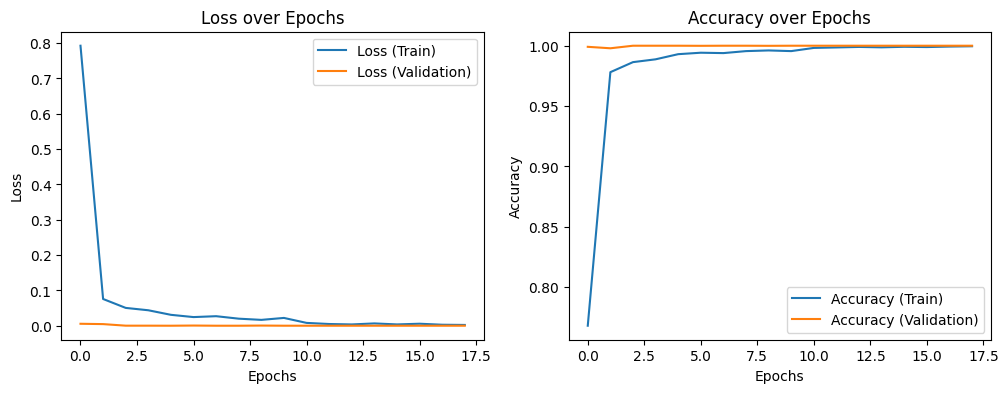

In [8]:
plt.figure(figsize=(12, 4))

# Loss cho tập huấn luyện
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy cho tập huấn luyện
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (Train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

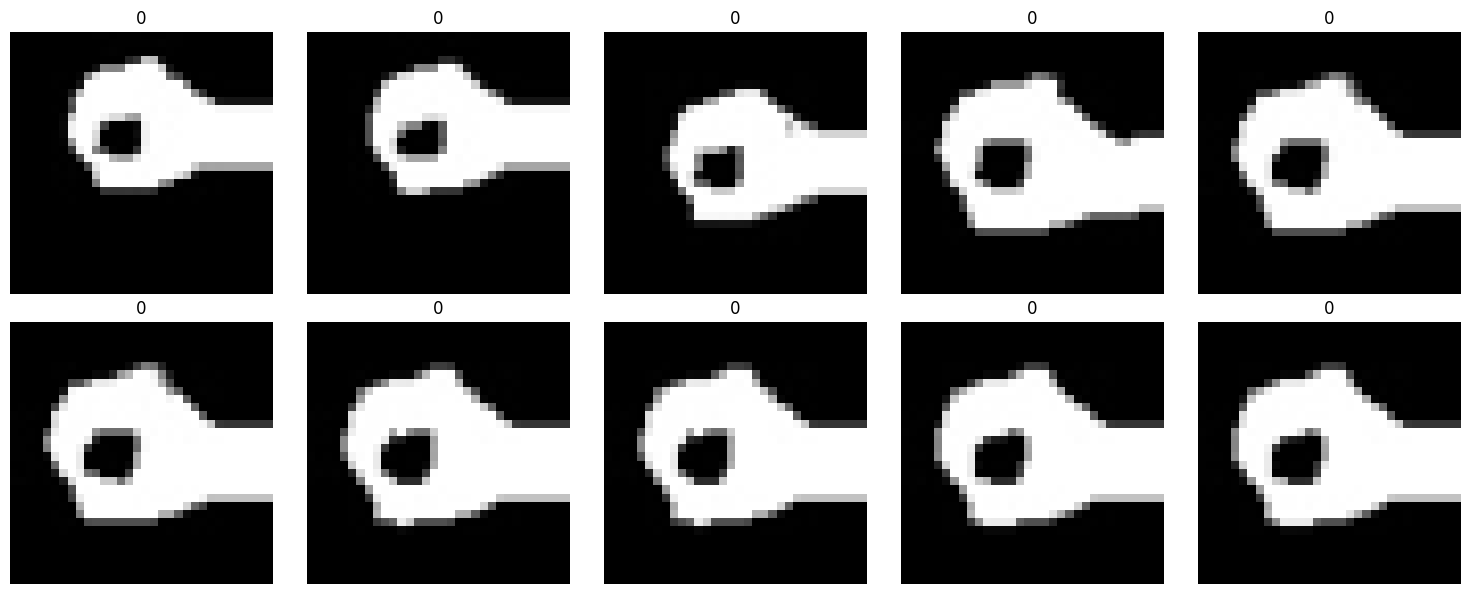

In [14]:
import matplotlib.pyplot as plt

# Giả sử X_train là mảng chứa hình ảnh
# Hiển thị một số hình ảnh từ tập huấn luyện
def display_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 6))

    for i in range(num_images):
        plt.subplot(2, 5, i + 1)  # Hiển thị trong lưới 2x5
        plt.imshow(images[i])  # Hiển thị hình ảnh
        plt.title(class_names[np.argmax(labels[i])])  # Gán tiêu đề là tên lớp
        plt.axis('off')  # Tắt trục

    plt.tight_layout()
    plt.show()
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
               'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# Gọi hàm để hiển thị hình ảnh
display_images(X_train, Y_train, class_names, num_images=10)
